reference video: https://www.youtube.com/watch?v=jztwpsIzEGc&t=981s

In [2]:
import cv2
from matplotlib import pyplot as plt

We now try to take the data folder, and split it into multiple data folders, each of these folders containing one individual picture classification

BEFORE RUNNING THIS STEP: please have image folder in parent directory and data_classes folder in experimental


In [7]:

import os
import shutil


classes=set()

for image in os.listdir("../images"):
    classes.add(image[:2])

newlist=[]


for classname in list(classes):
    newstring=""
    for char in classname:
        if char.isnumeric():
            newstring+=char
    newlist.append(int(newstring))


parent_dir="../experimental/data_classes"
imagePath="../images"

for num in (newlist):
    dir_path = os.path.join(parent_dir, str(num))
    os.makedirs(dir_path, exist_ok=True)
    
    print(f"Directory {dir_path} created.")


for imagefilename in os.listdir("../images"):
    newstring=""
    for char in imagefilename[:2]:
        if char.isnumeric():
            newstring+=char
    targetdirectory=os.path.join(parent_dir, newstring)
    newimagepath=os.path.join(imagePath, imagefilename)
    shutil.move(newimagepath, targetdirectory)
    print("image moved")






Directory ../experimental/data_classes/7 created.
Directory ../experimental/data_classes/14 created.
Directory ../experimental/data_classes/22 created.
Directory ../experimental/data_classes/2 created.
Directory ../experimental/data_classes/5 created.
Directory ../experimental/data_classes/10 created.
Directory ../experimental/data_classes/17 created.
Directory ../experimental/data_classes/11 created.
Directory ../experimental/data_classes/12 created.
Directory ../experimental/data_classes/9 created.
Directory ../experimental/data_classes/15 created.
Directory ../experimental/data_classes/16 created.
Directory ../experimental/data_classes/4 created.
Directory ../experimental/data_classes/13 created.
Directory ../experimental/data_classes/1 created.
Directory ../experimental/data_classes/6 created.
Directory ../experimental/data_classes/21 created.
Directory ../experimental/data_classes/0 created.
Directory ../experimental/data_classes/18 created.
Directory ../experimental/data_classes/

image resizing testing, using this technique we can successfully resize the image to a standard size of 128,128,3, without sacrificing any major features of the photo 

(402, 491, 3)
(128, 128, 3)


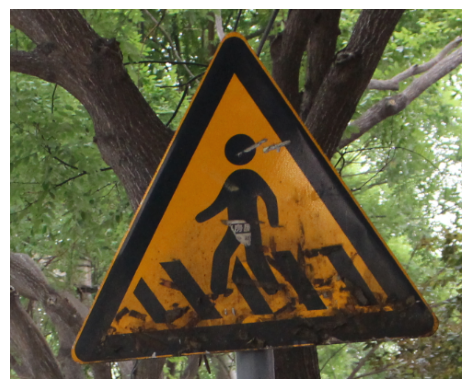

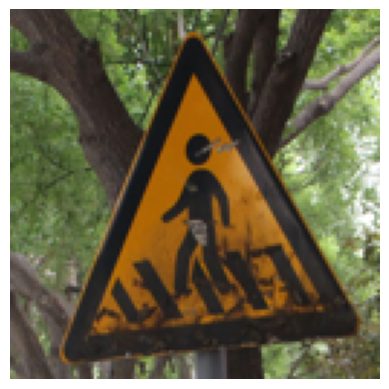

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

'''
img = Image.open('../experimental/data_classes/10/10_577.png') 
new_img = img.resize((128, 128))
new_img.save("../experimental/resized_image/image.png")
'''

old_img_array=cv2.imread('../experimental/data_classes/10/10_577.png')
new_img_array=cv2.imread("../experimental/resized_image/image.png")
print(old_img_array.shape)
print(new_img_array.shape)


plt.imshow(cv2.cvtColor(old_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

plt.imshow(cv2.cvtColor(new_img_array, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

Now we try to construct an image daatset from our image_directory, which is already nicely split up for us. There is a keras library for this:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt

data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(256, 256),
                                                batch_size=64,
                                                )

data_iterator= data.as_numpy_iterator()
batch=data_iterator.next()
print(batch[0].shape) #indepenedant variables i.e pixel values
print(batch[1].shape) #y labels


Found 4896 files belonging to 23 classes.
(64, 256, 256, 3)
(64,)


lets have a look at the max and min values of each pixel, we can see that pixels take a max and min value of 255 and 0 respectively. This means that to normalise, we simply take the values and divide it by range: 255

In [5]:
print("Max value of pixels: ", batch[0].max())
print("Min value of pixels: ", batch[0].min())

Max value of pixels:  255.0
Min value of pixels:  0.0


lets normalise the data, run this only ONCE PLEASE

In [6]:
data=data.map(lambda x, y: (x/255, y))

as can be seen, values should now be represented in zero to one ranges

In [7]:
scaled_data_iterator=data.as_numpy_iterator()
scaled_batch=scaled_data_iterator.next()
print(scaled_batch[0].min())
print(scaled_batch[0].max())

0.0
1.0


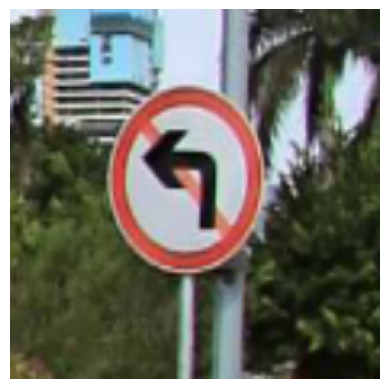

In [8]:
example_image = scaled_batch[0][0] 
plt.imshow(example_image)  
plt.axis('off')  
plt.show()

With a batch size of 64, there are still 77 batches, so we will split it into train, test, and validation sets. 

train set= 70%
validation set= 20%
test set= 10%


In [9]:
numBatch=len(data)
trainsize=int(0.7*numBatch)
valsize=int(0.2*numBatch)+1
testsize=int(0.1*numBatch)+1


now we distribute the train, val and test set

In [13]:
train=data.take(trainsize)
val=data.skip(trainsize).take(valsize)
test=data.skip(trainsize+valsize).take(testsize)

In [12]:
print(len(train))
print(len(val))
print(len(test))

53
16
8


In [105]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [15]:
model=Sequential()

In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(23, activation='softmax'))

/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


as we can see the output is not one hot encoded, so we use sparese 

In [17]:
train.as_numpy_iterator().next()[1]

array([ 0, 21,  9,  2, 12, 19,  2, 11,  1,  5,  0, 14,  1, 18, 12,  3,  0,
       13, 12,  1, 16, 19, 12, 16, 17,  0,  0, 16, 20,  0, 22,  2,  4, 18,
       13, 16, 20, 16,  1, 16,  8,  2,  6,  7, 12, 21,  0, 21,  7, 17, 19,
       16, 20, 10, 21,  1,  5, 19,  8,  6,  0, 14, 19,  0], dtype=int32)

In [18]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         5,911 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,702,279 (14.12 MB)

 Trainable params: 3,702,279 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Initial model training, testing if model is good enough or more training data needed

In [21]:
hist = model.fit(train, batch_size=64, epochs=5, validation_data=val, callbacks=[tensorboard_callback], verbose=1)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2863 - loss: 2.4885 - val_accuracy: 0.7764 - val_loss: 0.7150
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8494 - loss: 0.5054 - val_accuracy: 0.9453 - val_loss: 0.1662
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9638 - loss: 0.1045 - val_accuracy: 0.9893 - val_loss: 0.0430
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9932 - loss: 0.0288 - val_accuracy: 0.9902 - val_loss: 0.0364
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9988 - loss: 0.0109 - val_accuracy: 0.9951 - val_loss: 0.0377


In [22]:
model.save("../experimental/models/vanilla_model.keras")

Testing and evaluating model, we can see that for first implementation, it already does pretty well

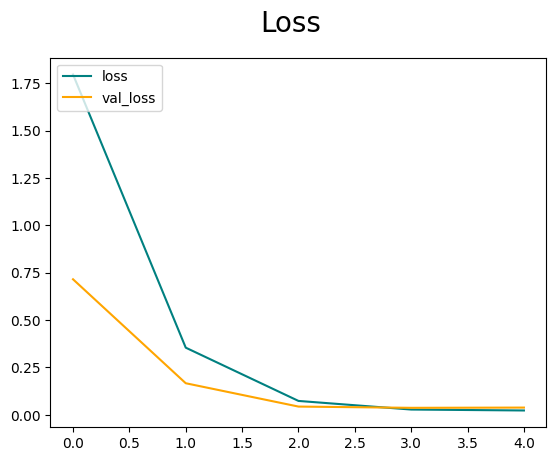

In [23]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

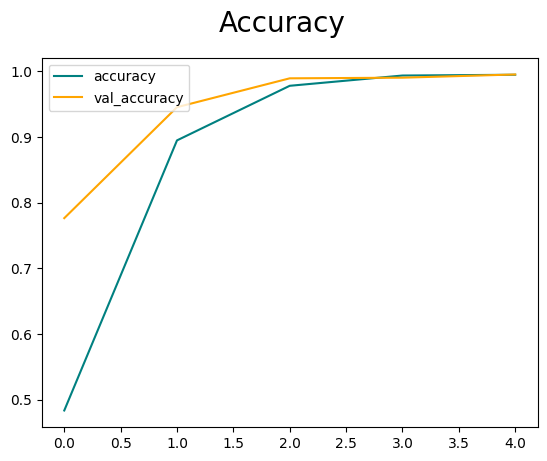

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [14]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import numpy as np
import keras
from keras import ops

In [15]:
pre=Precision()
rec=Recall()
acc=Accuracy()

reconstructed_vanilla_model=keras.models.load_model("../experimental/models/vanilla_model.keras") 

In [16]:
for batch in test.as_numpy_iterator():
    x,y=batch
    predicted=reconstructed_vanilla_model.predict(x)
    yhat=np.argmax(predicted, axis=1)
    acc.update_state(y, yhat)
    rec.update_state(y, yhat)
    pre.update_state(y, yhat)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


2024-10-24 14:29:08.887848: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Impressive results with testing data(completely unseen with model), with a 99.7% precision, 97.9% accuracy and a perfect recall, but is this model really robust?

In [17]:
print(pre.result(), rec.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


Possible room for improvement?

- Bigger dataset, take training data and distort some, rotate some images, etc: helps the CNN recognise key features of the signs


In [35]:
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)
    return image + noise

In [78]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
    tf.keras.layers.RandomRotation(1),                    
    tf.keras.layers.RandomZoom(1),
    tf.keras.layers.RandomContrast(1)  

])

In [79]:
def augment_with_noise(image, label):
    image=image/255
    image = data_augmentation(image)
    image = add_gaussian_noise(image)
    return image, label

In [93]:
augmented_data=tf.keras.utils.image_dataset_from_directory("../experimental/data_classes",
                                                image_size=(256, 256),
                                                batch_size=64,
                                                )

augmented_data = augmented_data.map(augment_with_noise) 

augmented_next=augmented_data.as_numpy_iterator()
augmented_next_batch=augmented_next.next()
print(augmented_batch[0].shape) #indepenedant variables i.e pixel values
print(augmented_batch[1].shape) #y labels

Found 4896 files belonging to 23 classes.
(64, 256, 256, 3)
(64,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.33354276..1.184527].


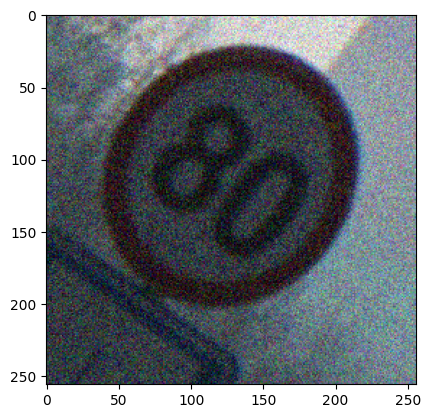

In [96]:
example_image = augmented_batch[0][23]
plt.imshow(example_image)   
plt.show()

In [97]:
augmented_train=augmented_data.take(trainsize)
augmented_val=augmented_data.skip(trainsize).take(valsize)
augmented_test=augmented_data.skip(trainsize+valsize).take(testsize)

In [98]:
print(len(augmented_train))

53


In [99]:
augmented_pre=Precision()
augmented_rec=Recall()
augmented_acc=Accuracy()

Testing original vanilla model on augmented data

In [100]:
for batch in augmented_test.as_numpy_iterator():
    x,y=batch
    predicted=reconstructed_vanilla_model.predict(x)
    yhat=np.argmax(predicted, axis=1)
    augmented_pre.update_state(y, yhat)
    augmented_rec.update_state(y, yhat)
    augmented_acc.update_state(y, yhat)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


CHANGE THIS SOON: All other metrics dont matter, there is only positive and negative, but we can see that accuray drops from 100% to 20%

In [103]:
print(augmented_acc.result())

tf.Tensor(0.18958333, shape=(), dtype=float32)


Now we see that the model is actually not too robust to rotations, cropping and the addition of noise. 

In [106]:
augmented_model=Sequential()

augmented_model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(32, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Conv2D(16, (3,3), 1, activation='relu'))
augmented_model.add(MaxPooling2D())
augmented_model.add(Flatten())
augmented_model.add(Dense(256, activation='relu'))
augmented_model.add(Dense(23, activation='softmax'))

/Users/sydneysim/Documents/Y2S1/IT1244/project/IT1244_Project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [107]:
augmented_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [108]:
logdir_augmented='logs_augmented'
tensorboard_callback_augmented = tf.keras.callbacks.TensorBoard(log_dir=logdir_augmented)

In [110]:
hist_augmented = augmented_model.fit(augmented_train, batch_size=64, epochs=10, validation_data=augmented_val, callbacks=[tensorboard_callback_augmented], verbose=1)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.1460 - loss: 3.1111 - val_accuracy: 0.2744 - val_loss: 2.1666
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.3338 - loss: 2.0769 - val_accuracy: 0.4043 - val_loss: 1.7724
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.4091 - loss: 1.7872 - val_accuracy: 0.4648 - val_loss: 1.6181
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.4371 - loss: 1.6555 - val_accuracy: 0.4756 - val_loss: 1.4801
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4631 - loss: 1.5189 - val_accuracy: 0.4697 - val_loss: 1.5374
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.4741 - loss: 1.5088 - val_accuracy: 0.5176 - val_loss: 1.3794
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5143 - loss: 1.3658 - val_accuracy: 0.5312 - val_loss: 1.3246
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5227 - loss: 1.3461 - val_accuracy: 0.5664 - v